In [1]:
!pip install tensorflow numpy matplotlib scikit-learn


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Set dataset paths
train_dir = "/Users/harishgowda/Downloads/Lychee Disease Augmentation Dataset"  # Update path
val_dir = "/Users/harishgowda/Downloads/Lychee Disease Augmentation Dataset"      # Update path
test_dir = "/Users/harishgowda/Downloads/Lychee Disease Augmentation Dataset"    # Update path


In [7]:

# ✅ Image size & batch size
img_size = (224, 224)  # ResNet-18 input size
batch_size = 32  
num_classes = 10  # Update based on your dataset


# ✅ Data Augmentation for Better Accuracy
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# ✅ Load Training Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# ✅ Load Validation Data
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [63]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [9]:
# ✅ Load Pretrained ResNet-50V2 & Convert to ResNet-18
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Convert ResNet-50V2 to ResNet-18 (Train Only Last 18 Layers)
for layer in base_model.layers[:-18]:  
    layer.trainable = False  # Freeze all layers except the last 18

# ✅ Add Fully Connected Layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Dropout for Regularization
output_layer = Dense(num_classes, activation='softmax')(x)

# ✅ Create Model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Save Best Model During Training
checkpoint = ModelCheckpoint("best_resnet18_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")

# ✅ Train Model for 50 Epochs (NO Early Stopping)
epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint] 
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.6344 - loss: 1.2137 - val_accuracy: 0.8485 - val_loss: 0.4735
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.9433 - loss: 0.1827 - val_accuracy: 0.8605 - val_loss: 0.4588
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9657 - loss: 0.1027 - val_accuracy: 0.8810 - val_loss: 0.4215
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9738 - loss: 0.0685 - val_accuracy: 0.8765 - val_loss: 0.4766
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.9814 - loss: 0.0613 - val_accuracy: 0.8900 - val_loss: 0.4085
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9820 - loss: 0.0519 - val_accuracy: 0.9010 - val_loss: 0.3859
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.9836 - loss: 0.0473 - val_accuracy: 0.8855 - val_loss: 0.5944
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9857 - loss: 0.0380 - val_accu

In [11]:
model.save('resnet_lychee.keras')

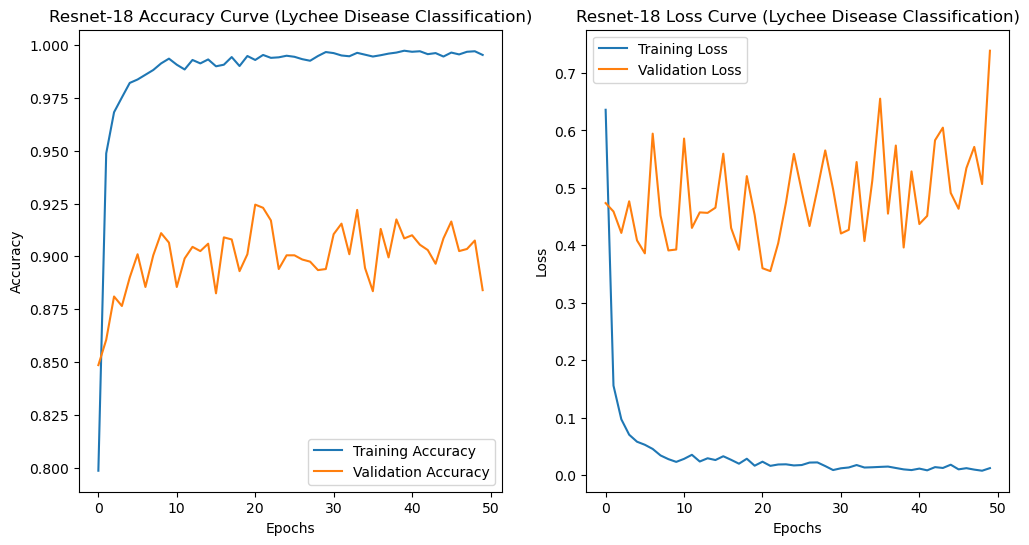

In [51]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Resnet-18 Accuracy Curve (Lychee Disease Classification)')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Resnet-18 Loss Curve (Lychee Disease Classification)')

plt.show()


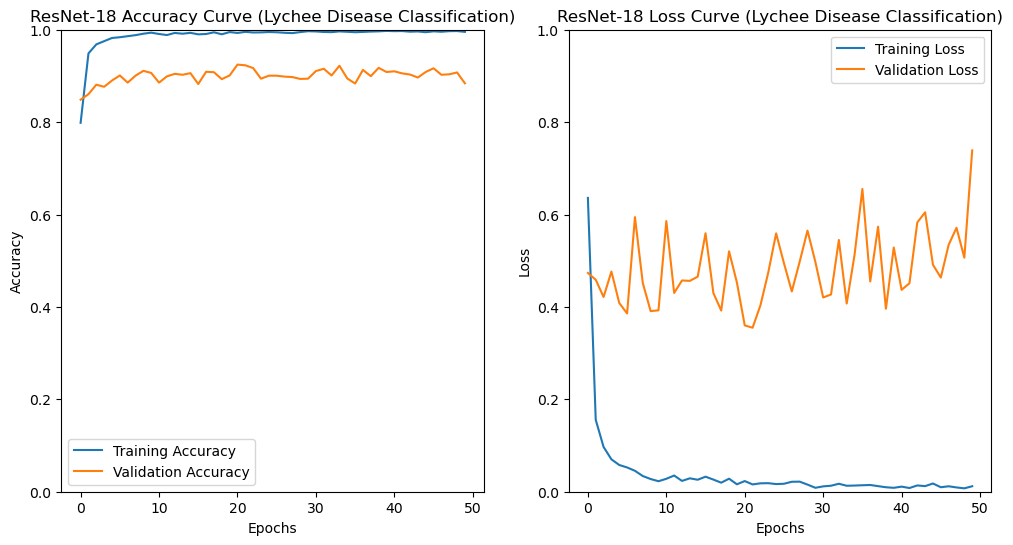

In [23]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # ✅ Set Y-axis from 0 to 1
plt.legend()
plt.title('ResNet-18 Accuracy Curve (Lychee Disease Classification)')

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # ✅ Set Y-axis from 0 to 1
plt.legend()
plt.title('ResNet-18 Loss Curve (Lychee Disease Classification)')

plt.show()


In [21]:
print("Calculating Model Accuracy for Lychee Disease Classification (Training Set)")
train_scores = model.evaluate(train_generator)
print(f"Training Accuracy: {train_scores[1] * 100:.2f}%")

print("Calculating Model Accuracy for Lychee Disease Classification (Validation Set)")
val_scores = model.evaluate(test_generator)  # Using test_generator as validation set
print(f"Validation Accuracy: {val_scores[1] * 100:.2f}%")

print("Calculating Model Accuracy for Lychee Disease Classification (Test Set)")
test_scores = model.evaluate(test_generator)
print(f"Test Accuracy: {test_scores[1] * 100:.2f}%")


Calculating Model Accuracy for Lychee Disease Classification (Training Set)
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 808ms/step - accuracy: 0.9995 - loss: 0.0024
Training Accuracy: 99.92%
Calculating Model Accuracy for Lychee Disease Classification (Validation Set)
313/313 ━━━━━━━━━━━━━━━━━━━━ 284s 906ms/step - accuracy: 0.9448 - loss: 0.3405
Validation Accuracy: 97.54%
Calculating Model Accuracy for Lychee Disease Classification (Test Set)
313/313 ━━━━━━━━━━━━━━━━━━━━ 287s 915ms/step - accuracy: 0.9532 - loss: 0.2887
Test Accuracy: 97.65%


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a validation data generator (same as train_generator but without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale, no augmentation for validation

# Define the validation data generator
val_generator = val_datagen.flow_from_directory(
    r"/Users/harishgowda/Downloads/Lychee Disease Augmentation Dataset",  # Path to validation data
    target_size=(224, 224),  # Image size for GoogLeNet
    batch_size=32,  # Batch size
    class_mode='categorical',  # Assuming categorical output
    shuffle=False  # No shuffling for validation generator
)


Found 10000 images belonging to 10 classes.


313/313 ━━━━━━━━━━━━━━━━━━━━ 259s 824ms/step


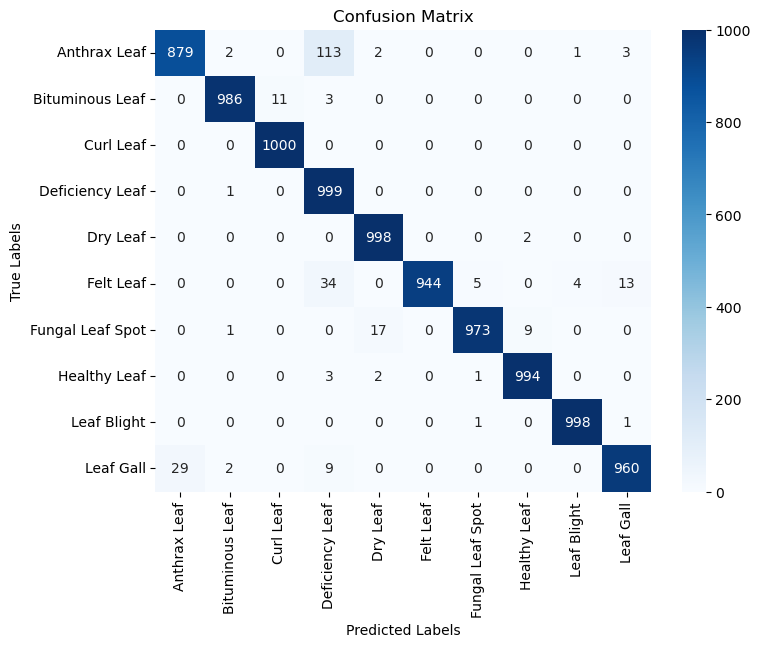

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true and predicted labels
y_true = val_generator.classes  # True labels from the validation generator
y_pred = np.argmax(model.predict(val_generator), axis=1)  # Predicted labels from the model

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=val_generator.class_indices.keys(), 
            yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [33]:
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes,y_pred))

Confusion Matrix
[[ 879    2    0  113    2    0    0    0    1    3]
 [   0  986   11    3    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    1    0  999    0    0    0    0    0    0]
 [   0    0    0    0  998    0    0    2    0    0]
 [   0    0    0   34    0  944    5    0    4   13]
 [   0    1    0    0   17    0  973    9    0    0]
 [   0    0    0    3    2    0    1  994    0    0]
 [   0    0    0    0    0    0    1    0  998    1]
 [  29    2    0    9    0    0    0    0    0  960]]


In [35]:
# Define your class names list
class_names = ['Leaf Gall', 'Leaf Blight', 'Healthy Leaf', 'Fungal Leaf Spot', 'Felt Leaf','Dry Leaf','Deficiency Leaf','Curl Leaf','Bituminous Leaf','Anthrax Leaf']

# Assuming y_true and y_pred are available (you should have these values calculated earlier)
# y_true = validation_generator.classes
# y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Function to print the classification report
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

# Call the function
print_classification_report(y_true, y_pred)


                  precision    recall  f1-score   support

       Leaf Gall       0.97      0.88      0.92      1000
     Leaf Blight       0.99      0.99      0.99      1000
    Healthy Leaf       0.99      1.00      0.99      1000
Fungal Leaf Spot       0.86      1.00      0.92      1000
       Felt Leaf       0.98      1.00      0.99      1000
        Dry Leaf       1.00      0.94      0.97      1000
 Deficiency Leaf       0.99      0.97      0.98      1000
       Curl Leaf       0.99      0.99      0.99      1000
 Bituminous Leaf       1.00      1.00      1.00      1000
    Anthrax Leaf       0.98      0.96      0.97      1000

        accuracy                           0.97     10000
       macro avg       0.98      0.97      0.97     10000
    weighted avg       0.98      0.97      0.97     10000



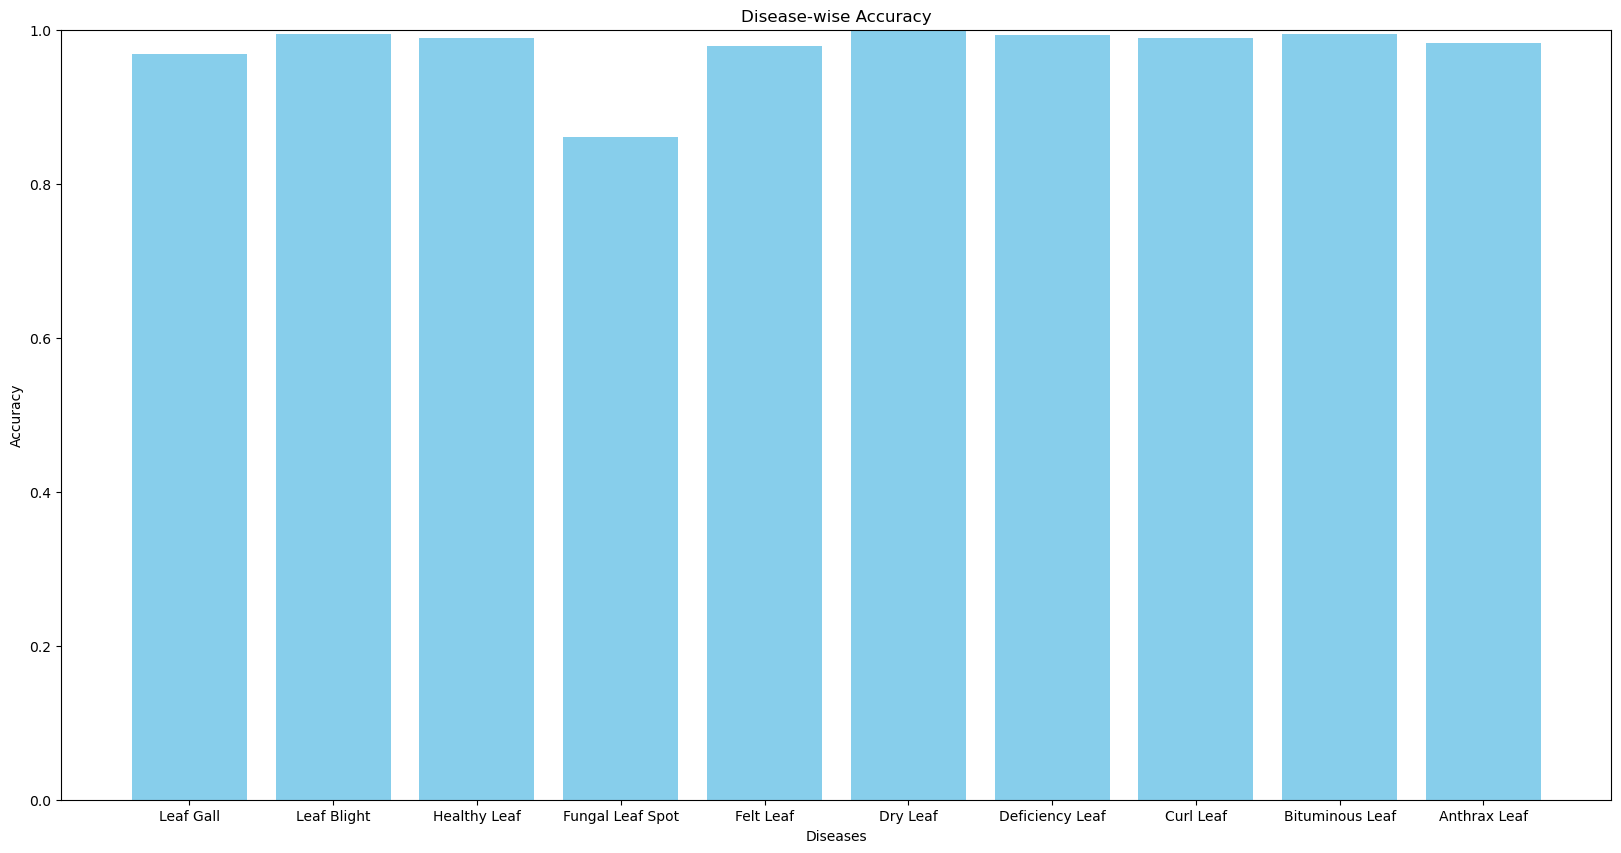

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define the class names based on your dataset
class_names = ['Leaf Gall', 'Leaf Blight', 'Healthy Leaf', 'Fungal Leaf Spot', 'Felt Leaf','Dry Leaf','Deficiency Leaf','Curl Leaf','Bituminous Leaf','Anthrax Leaf']

# Assuming y_true and y_pred are available (you should have these values calculated earlier)
# y_true = validation_generator.classes
# y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Function to plot disease-wise accuracy
def plot_disease_accuracy(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    accuracy = [report[cls]['precision'] for cls in class_names]  # Precision as an indicator
    df = pd.DataFrame({'Disease': class_names, 'Accuracy': accuracy})

    plt.figure(figsize=(20, 10))
    plt.bar(df['Disease'], df['Accuracy'], color='skyblue')
    plt.title('Disease-wise Accuracy')
    plt.xlabel('Diseases')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Call the function
plot_disease_accuracy(y_true, y_pred, class_names)


In [39]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    r"/Users/harishgowda/Downloads/Lychee Disease Augmentation Dataset", 
    target_size=(224, 224),  # Ensure images are resized to 224x224
    batch_size=32,
    class_mode='categorical'  # or 'binary', depending on your setup
)


Found 10000 images belonging to 10 classes.


In [41]:
Y_pred = model.predict(val_generator)


313/313 ━━━━━━━━━━━━━━━━━━━━ 247s 790ms/step


In [43]:
from sklearn.preprocessing import label_binarize

# Get true labels from the validation generator
y_true = val_generator.classes

# Binarize true labels (for multi-class ROC/AUC calculations)
y_true_binarized = label_binarize(y_true, classes=np.arange(len(val_generator.class_indices)))

# Get predicted probabilities
Y_pred = model.predict(val_generator)
Y_pred_main = Y_pred  # No need to extract index, as it's a single output model

# Print the shapes
print("Shape of y_true:", y_true.shape)
print("Shape of y_true_binarized:", y_true_binarized.shape)
print("Shape of Y_pred (main output):", Y_pred_main.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 276s 880ms/step
Shape of y_true: (10000,)
Shape of y_true_binarized: (10000, 10)
Shape of Y_pred (main output): (10000, 10)


In [45]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_true_binarized = lb.fit_transform(y_true)  # Assuming y_true is the true class labels


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(val_generator, steps=int(np.ceil(val_generator.n / val_generator.batch_size)))

# Convert predictions to class labels
y_pred = np.argmax(Y_pred, axis=1)

# True labels from the validation generator
y_true = val_generator.classes

# Debugging: Check if the lengths match before truncating
print(f"Number of predictions: {len(y_pred)}")
print(f"Number of true labels: {len(y_true)}")

# Ensure the number of predictions matches the number of true labels
if len(y_pred) != len(y_true):
    print("Warning: The length of predictions and true labels do not match.")
    # Truncate or extend y_pred to match the length of y_true
    y_pred = y_pred[:len(y_true)]
    print(f"Truncated predictions: {len(y_pred)}")

# Ensure the validation generator is reset and predictions are correct
val_generator.reset()

# Predict on the validation data
Y_pred = model.predict(val_generator, steps=int(np.ceil(val_generator.n / val_generator.batch_size)))

# Convert predictions to class indices
y_pred = np.argmax(Y_pred, axis=1)

# True labels from the validation generator
y_true = val_generator.classes

# Check if the lengths of y_true and y_pred are consistent
print(f"Number of predictions: {len(y_pred)}")
print(f"Number of true labels: {len(y_true)}")

# If there is a mismatch, truncate or extend y_pred to match y_true
if len(y_pred) != len(y_true):
    y_pred = y_pred[:len(y_true)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 273s 872ms/step
Number of predictions: 10000
Number of true labels: 10000
313/313 ━━━━━━━━━━━━━━━━━━━━ 278s 888ms/step
Number of predictions: 10000
Number of true labels: 10000


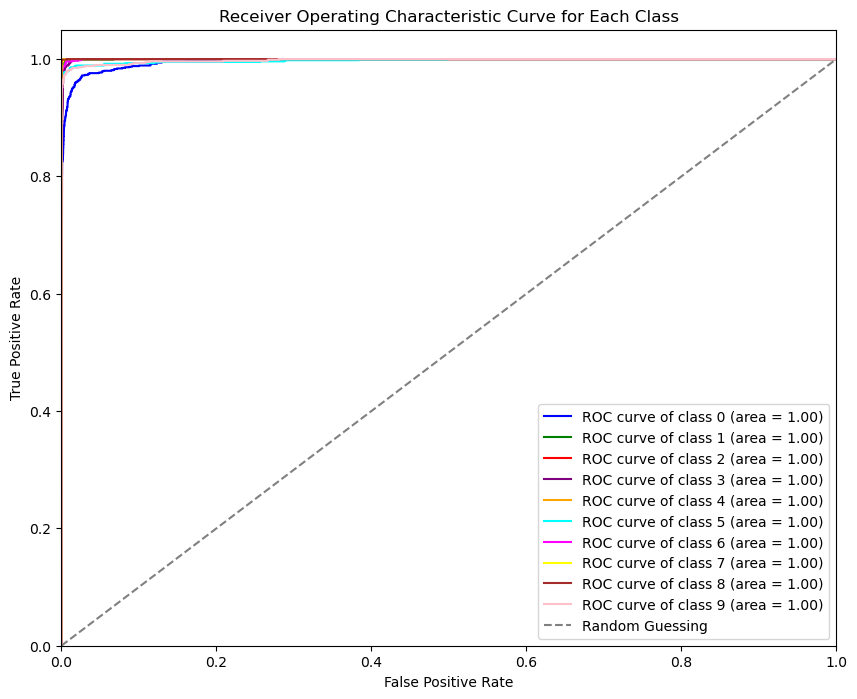

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Number of classes
n_classes = 10  # Update for your number of classes

# Convert y_true and Y_pred to numpy arrays
y_true = np.array(y_true)
Y_pred = np.array(Y_pred)

# Ensure y_true_binarized is one-hot encoded
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

# Extract predictions from the first model or fold
Y_pred_single = Y_pred  # No need for [0], it should already be the predictions

# Check if Y_pred_single is the correct shape
if Y_pred_single.ndim != 2 or Y_pred_single.shape[1] != n_classes:
    raise ValueError("Y_pred_single should be a 2D array with shape (n_samples, n_classes)")

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], Y_pred_single[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define 10 unique colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 
          'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Each Class')
plt.legend(loc='lower right')
plt.show()
